In [1]:
import os
import sys
import json
sys.path.append("..")
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np
from settings import PROJECT_PATH, CLASSIFICATION_TARGET, REGRESSION_TARGET
from mlflow.tracking import MlflowClient

In [2]:
data = pd.read_parquet(os.path.join(PROJECT_PATH, 'data/interim/transactions_post_feature_engineering.parquet'))
data.head()

,prix,vefa,surface_habitable,latitude,longitude,mois_transaction,annee_transaction,en_dessous_du_marche,prix_m2_moyen_mois_precedent,nb_transactions_mois_precedent,ville_demandee,type_batiment_Maison,nom_region_Nouvelle-Aquitaine,nom_region_Occitanie,nom_region_Provence-Alpes-Côte d'Azur,nom_region_Île-de-France
0,30000.0,0,34,46.210785,5.228714,6,2018,1,1241.19,11.0,1,0,0,0,0,0
1,73000.0,0,77,46.190439,5.238234,6,2018,1,1241.19,11.0,1,0,0,0,0,0
2,185000.0,0,107,46.196411,5.274976,6,2018,0,1241.19,11.0,1,1,0,0,0,0
3,65000.0,0,65,46.211106,5.219147,6,2018,1,1241.19,11.0,1,0,0,0,0,0
4,84000.0,0,86,46.213257,5.228674,6,2018,1,1241.19,11.0,1,0,0,0,0,0


In [3]:
data.shape

(468115, 16)

In [4]:
with open ("../preprocessing/features_used/features_name.json", "r") as f :
    features_name = json.load (f)

with open("../preprocessing/features_used/numerical_features.json", "r") as f :
    numerical_features= json.load(f)
print(features_name)
print(numerical_features)

['prix', 'vefa', 'surface_habitable', 'latitude', 'longitude', 'mois_transaction', 'annee_transaction', 'en_dessous_du_marche', 'prix_m2_moyen_mois_precedent', 'nb_transactions_mois_precedent', 'ville_demandee', 'type_batiment_Maison', 'nom_region_Nouvelle-Aquitaine', 'nom_region_Occitanie', "nom_region_Provence-Alpes-Côte d'Azur", 'nom_region_Île-de-France']
['surface_habitable', 'latitude', 'longitude', 'mois_transaction', 'annee_transaction', 'prix_m2_moyen_mois_precedent', 'nb_transactions_mois_precedent']


In [5]:
categorial_features = [col for col in features_name if col not in numerical_features and col not in [REGRESSION_TARGET,CLASSIFICATION_TARGET]]
print(categorial_features)

['vefa', 'ville_demandee', 'type_batiment_Maison', 'nom_region_Nouvelle-Aquitaine', 'nom_region_Occitanie', "nom_region_Provence-Alpes-Côte d'Azur", 'nom_region_Île-de-France']


In [6]:
# Copie du Df d'origine
df = data.copy()
# Séparation du Df en trainset et testset
trainset,testset= train_test_split(df, test_size=0.2, random_state=0)

print(f'Nombre d\'échantillons du trainset: {trainset.shape[0]}')
print(f"proportion de biens en dessous du marché dans le trainset:{round(trainset['en_dessous_du_marche'].value_counts(normalize=True)[1],2)}")
print(f'Nombre d\'échantillons du testset: {testset.shape[0]}')
print(f"proportion de biens en dessous du marché dans le testset:{round(testset['en_dessous_du_marche'].value_counts(normalize=True)[1],2)}")

Nombre d'échantillons du trainset: 374492
proportion de biens en dessous du marché dans le trainset:0.37
Nombre d'échantillons du testset: 93623
proportion de biens en dessous du marché dans le testset:0.37


In [7]:
X_train= trainset.drop([REGRESSION_TARGET,CLASSIFICATION_TARGET],axis=1)
y_train_regression = trainset[REGRESSION_TARGET]
y_train_classification = trainset[CLASSIFICATION_TARGET]

In [8]:
X_test= testset.drop([REGRESSION_TARGET,CLASSIFICATION_TARGET],axis=1)
y_test_regression = testset[REGRESSION_TARGET]
y_test_classification = testset[CLASSIFICATION_TARGET]

In [9]:
def perform_cross_validation(
    X: pd.DataFrame,
    y: pd.Series,
    model,
    cross_val_type,
    scoring_metrics: tuple,
    groupes=None,
):
    """
    Effectue une validation croisée pour un modèle donné et retourne les scores
    d'entraînement et de test, ainsi que le modèle ajusté.

    Paramètres :
    ----------
    X : pd.DataFrame
        Les données d'entrée (features) au format pandas DataFrame.
    y : pd.Series
        Les étiquettes ou cibles au format pandas Series.
    modele : object
        Modèle d'apprentissage supervisé (ex : un modèle sklearn) à valider.
    cross_val_type : int, générateur ou objet de type cross-validation
        La stratégie de validation croisée à utiliser (ex : KFold, StratifiedKFold).
    scoring_metrics : tuple
        Les métriques d'évaluation pour la validation croisée
        (ex : ('accuracy', 'f1')).
    groupes : array-like, optionnel
        Groupes utilisés pour certaines stratégies de validation croisée
        comme GroupKFold.

    Retourne :
    ---------
    scores : dict
        Les scores obtenus pour chaque métrique durant la validation croisée.
    scores_dict : dict
        Moyennes et écarts-types des scores pour chaque métrique.
    modele : object
        Le modèle ajusté sur l'ensemble complet des données (X, y).

    Exemple d'appel :
    -----------------
    >>> from sklearn.ensemble import RandomForestClassifier
    >>> from sklearn.model_selection import KFold
    >>> X = pd.DataFrame({'feature1': [1, 2, 3], 'feature2': [4, 5, 6]})
    >>> y = pd.Series([0, 1, 0])
    >>> modele = RandomForestClassifier()
    >>> cross_val_type = KFold(n_splits=3)
    >>> scoring_metrics = ('accuracy', 'f1')
    >>> scores, scores_dict, model = effectuer_validation_croisée(X, y, model, cross_val_type, scoring_metrics)
    """
    # Effectuer la validation croisée
    scores = cross_validate(
        model,
        X.values,  # Convertir DataFrame en tableau NumPy
        y.values,  # Convertir Series en tableau NumPy
        cv=cross_val_type,
        return_train_score=True,
        return_estimator=True,
        scoring=scoring_metrics,
        groups=groupes,
    )

    # Calculer les moyennes et écarts-types pour chaque métrique
    scores_dict = {}
    for metrique in scoring_metrics:
        scores_dict["moyenne_train_" + metrique] = np.mean(scores["train_" + metrique])
        scores_dict["ecart_type_train_" + metrique] = np.std(scores["train_" + metrique])
        scores_dict["moyenne_test_" + metrique] = np.mean(scores["test_" + metrique])
        scores_dict["ecart_type_test_" + metrique] = np.std(scores["test_" + metrique])

    # Ajuster le modèle sur l'ensemble des données
    model.fit(X.values, y.values)

    return scores, scores_dict, model

In [10]:
X_train.columns

Index(['vefa', 'surface_habitable', 'latitude', 'longitude',
       'mois_transaction', 'annee_transaction', 'prix_m2_moyen_mois_precedent',
       'nb_transactions_mois_precedent', 'ville_demandee',
       'type_batiment_Maison', 'nom_region_Nouvelle-Aquitaine',
       'nom_region_Occitanie', 'nom_region_Provence-Alpes-Côte d'Azur',
       'nom_region_Île-de-France'],
      dtype='object')

## Initialisation du workflow mlflow

In [11]:
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")

In [12]:
mlflow.set_tracking_uri(os.path.join(PROJECT_PATH,"mlruns"))


## Premier experiment

In [13]:
experiment_name = "classification_models"
experiment_tags = {
        "phase": "Model_Comparison",
        "revision_de_donnees": "v1",
        "date_de_construction": "Janvier 2025"
    }

In [14]:
# Créer ou définir l'expérience
client = MlflowClient()
try:
    # Tente de créer une nouvelle expérience
    experiment_id = client.create_experiment(name=experiment_name, tags=experiment_tags)
    print(f"Nouvelle expérience créée avec l'ID : {experiment_id}")
except Exception as e:
    # Si l'expérience existe déjà, récupère son ID
    print(f"L'expérience existe déjà : {str(e)}")
    experiment = client.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id

# Définir l'expérience active
mlflow.set_experiment(experiment_name)
print(f"Expérience définie : {experiment_name} (ID : {experiment_id})")

L'expérience existe déjà : Experiment 'classification_models' already exists.
Expérience définie : classification_models (ID : 961186934798174615)


## Random forest model

from sklearn.ensemble import RandomForestClassifier
import mlflow
import mlflow.sklearn
from sklearn.model_selection import TimeSeriesSplit

# Configuration des paramètres spécifiques pour cette combinaison
random_state = 42
n_estimators = 50
max_depth = 50
min_samples_split = 10
min_samples_leaf = 5
max_features = 'log2'
bootstrap = True


with mlflow.start_run(run_name="random_forest_classifier_complete_df_2") as run:
    # Ajout des tags au run MLflow
    mlflow.set_tags({
        "Experiment_Type": "models_comparison",
        "Phase": "selection",
        "Model_Type": "Random Forest Classifier",
        "Task": "Classification",
        "Run_Type": "Optimization",
        "Solver": "base",
        "Dataset": "trainset",
        "CV_Method": "TimeSeriesSplit",
        "CV_Folds": 5
    })

    # Modèle RandomForestClassifier avec cette combinaison de paramètres
    rf_model = RandomForestClassifier(
        random_state=random_state,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap
    )

    # Validation croisée avec TimeSeriesSplit
    classification_scoring_metrics = ["recall", "precision", "f1"]

    scores, scores_dict, rf_model = perform_cross_validation(
        X=X_train,  # Pas de standardisation ici
        y=y_train_classification,
        model=rf_model,
        cross_val_type=TimeSeriesSplit(5),
        scoring_metrics=classification_scoring_metrics,
    )

    # Enregistrement des paramètres et des métriques dans MLflow
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("min_samples_split", min_samples_split)
    mlflow.log_param("min_samples_leaf", min_samples_leaf)
    mlflow.log_param("max_features", max_features)
    mlflow.log_param("bootstrap", bootstrap)
    mlflow.log_metrics(scores_dict)

    # Exemple d'entrée pour le modèle
    input_example = X_train.head(1)
    mlflow.sklearn.log_model(rf_model, "random_forest_classifier", input_example=input_example)

    # Enregistrement du DataFrame en tant qu'artifact
    trainset_file = "trainset.csv"
    X_train.to_csv(trainset_file, index=False)
    mlflow.log_artifact(trainset_file)


# recherche des features importance du meilleur model testé

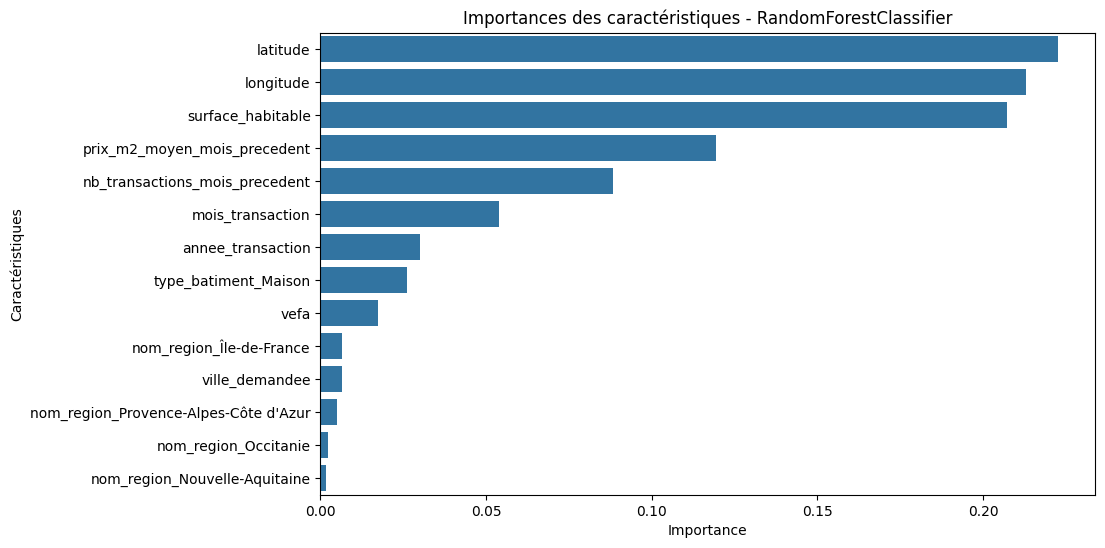

In [12]:
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le modèle depuis MLflow
model_uri = "/mnt/c/Users/mrgxl/Documents/cours françois/exercice python/Machine Learning/prediction_donnees_immobilieres/mlruns/961186934798174615/c6913bc605944944b184f70251998b2e/artifacts/random_forest_classifier"
model = mlflow.sklearn.load_model(model_uri)

# Récupérer les importances des caractéristiques et les noms des features
importances = model.feature_importances_
feature_names = X_train.columns  # Assurez-vous que X_train est défini

# Créer un DataFrame pour faciliter le tracé
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Trier les features par importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Tracer le barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title("Importances des caractéristiques - RandomForestClassifier")
plt.xlabel('Importance')
plt.ylabel('Caractéristiques')
plt.show()


In [110]:
top6_features = importances_df.head(6)
most_important_features =top6_features['Feature']

In [111]:
most_important_features

2                          latitude
3                         longitude
1                 surface_habitable
6      prix_m2_moyen_mois_precedent
7    nb_transactions_mois_precedent
4                  mois_transaction
Name: Feature, dtype: object

In [52]:

from sklearn.inspection import permutation_importance

def plot_permutation_importance_with_std(model, X, y, top_n=10, n_repeats=10):
    """
    Fonction pour afficher les importances des caractéristiques à l'aide de la méthode de permutation,
    avec les écarts-types pour chaque caractéristique.

    Args:
    - model: Un modèle d'apprentissage supervisé (par exemple, DecisionTreeClassifier, RandomForest, etc.).
    - X: Données d'entrée (features).
    - y: Cible.
    - top_n: Le nombre de caractéristiques à afficher (par défaut 10).
    - n_repeats: Le nombre de permutations pour évaluer la stabilité de l'importance (par défaut 10).
    """

    # Calculer l'importance des caractéristiques par permutation
    result = permutation_importance(model, X, y, n_repeats=n_repeats, random_state=42)

    # Extraire les importances et les écarts-types
    importance_values = result.importances_mean
    importance_std = result.importances_std

    # Créer un DataFrame pour combiner les importances et leur écart-type
    feature_names = X.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_values,
        'Std': importance_std
    })

    # Trier par importance
    importance_df = importance_df.sort_values(by="Importance", ascending=False)

    # Sélectionner les top_n caractéristiques
    importance_df = importance_df.head(top_n)

    # Affichage du barplot
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], xerr=importance_df['Std'], color='lightcoral')
    plt.xlabel('Importance')
    plt.title(f'Permutation Feature Importances with Standard Deviation (Top {top_n})')
    plt.show()




/mnt/c/Users/mrgxl/Documents/cours françois/exercice python/Machine Learning/prediction_donnees_immobilieres/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/mnt/c/Users/mrgxl/Documents/cours françois/exercice python/Machine Learning/prediction_donnees_immobilieres/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/mnt/c/Users/mrgxl/Documents/cours françois/exercice python/Machine Learning/prediction_donnees_immobilieres/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/mnt/c/Users/mrgxl/Documents/cours françois/exercice python/Machine Learning/prediction_donnees_immobilieres/.venv/lib/python3.11/sit

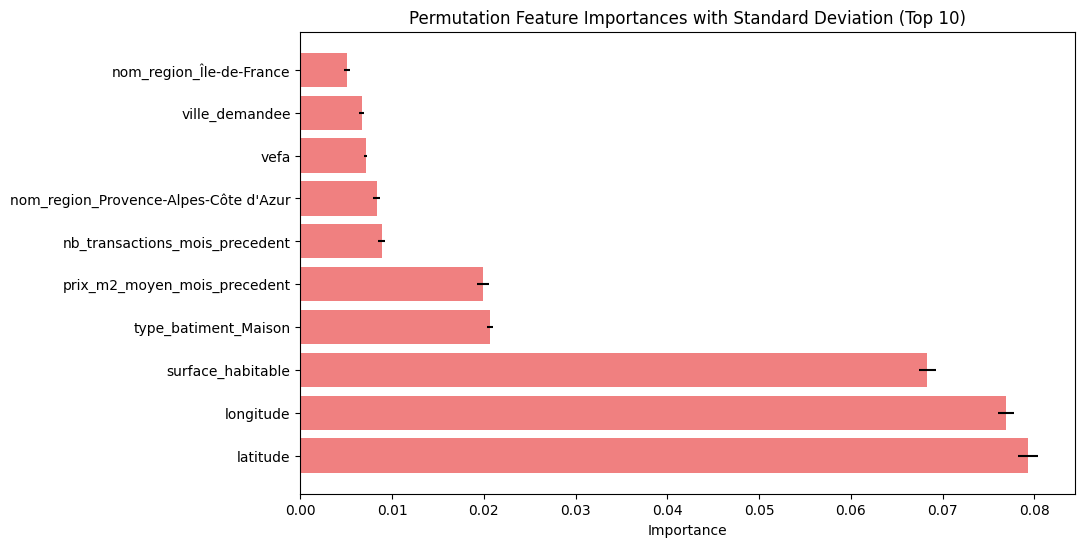

In [53]:
plot_permutation_importance_with_std(model, X_test, y_test_classification, top_n=10, n_repeats=10)

In [13]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
)

def classification_error_analysis(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    feature_names=None,
    average="binary",
    verbose=True,
    y_pred_adjusted=None
):
    """
    Effectue l'analyse des erreurs pour un modèle de classification, avec option pour fournir des prédictions ajustées.

    Parameters:
    -----------
    model : object
        Modèle entraîné qui implémente une méthode `predict`.
    X_train : pd.DataFrame or np.array
        Ensemble de données d'entraînement.
    y_train : pd.Series or np.array
        Cibles d'entraînement.
    X_test : pd.DataFrame or np.array
        Ensemble de données de test.
    y_test : pd.Series or np.array
        Cibles de test.
    feature_names : list or None, optional
        Liste des noms des colonnes à utiliser pour la prédiction. Si None, toutes les colonnes seront utilisées.
    average : str, optional
        Moyenne utilisée pour les métriques de classification multi-classes : "binary", "micro", "macro", ou "weighted".
    verbose : bool, optional
        Si True, affiche les métriques, le rapport de classification, et la matrice de confusion. Par défaut, True.
    y_pred_adjusted : np.array or None, optional
        Prédictions ajustées pour l'ensemble de test (par exemple avec un seuil modifié). Si None, utilise les prédictions par défaut du modèle.

    Returns:
    --------
    dict
        Dictionnaire contenant les métriques d'erreur pour les ensembles d'entraînement et de test.
    """
    if feature_names:
        X_train = X_train[feature_names]
        X_test = X_test[feature_names]

    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = y_pred_adjusted if y_pred_adjusted is not None else model.predict(X_test)

    # Calcul des métriques
    metrics = {
        "Train Accuracy": accuracy_score(y_train, y_train_pred),
        "Train Precision": precision_score(y_train, y_train_pred, average=average),
        "Train Recall": recall_score(y_train, y_train_pred, average=average),
        "Train F1": f1_score(y_train, y_train_pred, average=average),
        "Test Accuracy": accuracy_score(y_test, y_test_pred),
        "Test Precision": precision_score(y_test, y_test_pred, average=average),
        "Test Recall": recall_score(y_test, y_test_pred, average=average),
        "Test F1": f1_score(y_test, y_test_pred, average=average),
    }

    # Affichage des métriques, du rapport de classification et de la matrice de confusion
    if verbose:
        print("\nMetrics (Classification):")
        for key, value in metrics.items():
            print(f"{key}: {value:.4f}")

        print("\nClassification Report (Test Set):")
        print(classification_report(y_test, y_test_pred))

        print("\nConfusion Matrix (Test Set):")
        print(confusion_matrix(y_test, y_test_pred))




In [14]:
import mlflow
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Chemin du modèle enregistré dans MLflow (remplacez `best_model_path` par le chemin exact)
best_model_path = "/mnt/c/Users/mrgxl/Documents/cours françois/exercice python/Machine Learning/prediction_donnees_immobilieres/mlruns/961186934798174615/c6913bc605944944b184f70251998b2e/artifacts/random_forest_classifier"

# Charger le meilleur modèle depuis MLflow
best_model = mlflow.sklearn.load_model(best_model_path)

classification_error_analysis(
    best_model,
    X_train,
    y_train_classification,
    X_test,
    y_test_classification,
    feature_names=None,
    average="binary",
    verbose=True,
    y_pred_adjusted=None
)


/mnt/c/Users/mrgxl/Documents/cours françois/exercice python/Machine Learning/prediction_donnees_immobilieres/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/mnt/c/Users/mrgxl/Documents/cours françois/exercice python/Machine Learning/prediction_donnees_immobilieres/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



Metrics (Classification):
Train Accuracy: 0.8285
Train Precision: 0.8802
Train Recall: 0.6205
Train F1: 0.7279
Test Accuracy: 0.7111
Test Precision: 0.6702
Test Recall: 0.4399
Test F1: 0.5311

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.72      0.87      0.79     58792
           1       0.67      0.44      0.53     34831

    accuracy                           0.71     93623
   macro avg       0.70      0.66      0.66     93623
weighted avg       0.70      0.71      0.69     93623


Confusion Matrix (Test Set):
[[51252  7540]
 [19510 15321]]


## Courbe precision rappel du meilleur model


/mnt/c/Users/mrgxl/Documents/cours françois/exercice python/Machine Learning/prediction_donnees_immobilieres/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


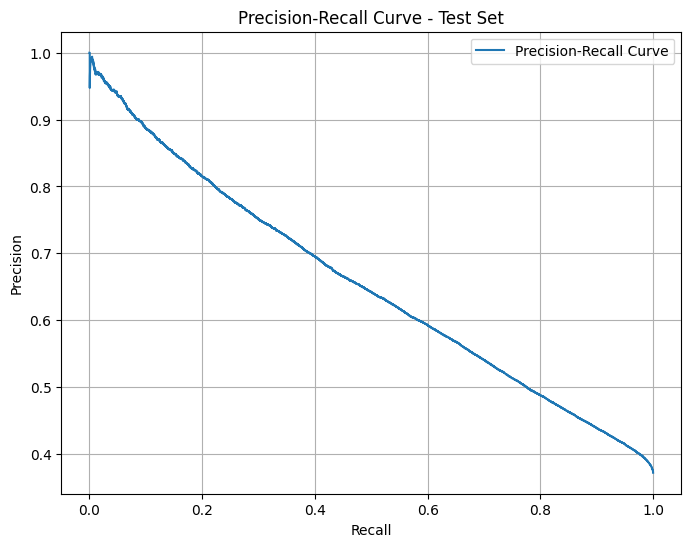

AUC de la courbe précision-rappel (test set) : 0.65


In [15]:

# Calcul des scores sur le test set
y_scores_test = best_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Courbe précision-rappel
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test_classification, y_scores_test)

# Tracé de la courbe précision-rappel
plt.figure(figsize=(8, 6))
plt.plot(recall_test, precision_test, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Test Set")
plt.legend()
plt.grid()
plt.show()

# Calcul de l'AUC de la courbe précision-rappel
auc_test = auc(recall_test, precision_test)
print(f"AUC de la courbe précision-rappel (test set) : {auc_test:.2f}")


## Analyse de la distribution des probabilités

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_prediction_type(prediction, target):
    """
    Cette fonction détermine le type d'une prédiction (vrai positif, faux positif, etc.).
    """
    if prediction == 1 and target == 1:
        return "true_positive"
    elif prediction == 0 and target == 0:
        return "true_negative"
    elif prediction == 1 and target == 0:
        return "false_positive"
    elif prediction == 0 and target == 1:
        return "false_negative"
    else:
        return "unknown"


def plot_probability_distribution(
        X,
        prediction_col="prediction",
        target_col="target",
        prob_col="probability_score",
        color_palette=None,
        categories_to_exclude=None):
    """
    Cette fonction trace la distribution des scores de probabilité en fonction du type de prédiction.

    X: pd.DataFrame
        Le DataFrame contenant les données.

    prediction_col: str
        Le nom de la colonne des prédictions.

    target_col: str
        Le nom de la colonne des vraies valeurs (cibles).

    prob_col: str
        Le nom de la colonne des scores de probabilité.

    color_palette: dict
        Un dictionnaire définissant les couleurs à utiliser pour chaque type de prédiction.

    categories_to_exclude: list
        Une liste des types de prédiction à exclure lors de l'analyse.
    """
    # Applique la fonction `get_prediction_type` à chaque ligne pour déterminer le type de prédiction
    X["prediction_type"] = X.apply(lambda row: get_prediction_type(row[prediction_col], row[target_col]), axis=1)

    # Filtre les catégories à exclure, si spécifié
    if categories_to_exclude is not None:
        X = X[~X["prediction_type"].isin(categories_to_exclude)]

    # Trace la distribution des scores de probabilité
    sns.displot(data=X, x=prob_col, hue="prediction_type", palette=color_palette)
    plt.legend(loc="upper right")
    plt.title("Distribution des Scores de Probabilité selon le Type de Prédiction")
    plt.show()


In [17]:
X_test_copy= X_test.copy()

In [18]:
# colonne à rajouter à X_test
X_test_copy['prediction']= (y_scores_test >= 0.5).astype(int)
X_test_copy['probability_score']= y_scores_test
X_test_copy['classification_target']= y_test_classification

In [19]:
X_test_copy["prediction_type"] = X_test_copy.apply(
    lambda row: get_prediction_type(row["prediction"], row["classification_target"]), axis=1
)

# Affichage pour vérifier
print(X_test_copy[["prediction", "classification_target", "prediction_type"]].head())


        prediction  classification_target prediction_type
176605           0                      0   true_negative
123391           1                      0  false_positive
342233           0                      0   true_negative
147447           0                      0   true_negative
185644           1                      1   true_positive


In [20]:
X_test_copy["prediction_type"].value_counts()

prediction_type
true_negative     51252
false_negative    19510
true_positive     15321
false_positive     7540
Name: count, dtype: int64

/tmp/ipykernel_23875/7977513.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


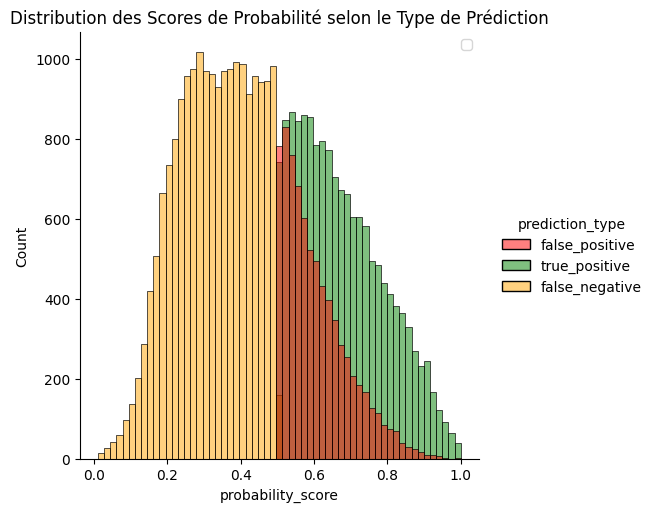

In [21]:
color_palette = {
    "true_positive": "green",
    "false_positive": "red",
    "false_negative": "orange",
    "true_negative": "blue"
}

# Tracer la distribution
plot_probability_distribution(
    X=X_test_copy,
    prediction_col="prediction",
    target_col="classification_target",
    prob_col="probability_score",
    color_palette=color_palette,
    categories_to_exclude=["true_negative"]  # Optionnel : Exclure certaines catégories
)

/tmp/ipykernel_23875/7977513.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


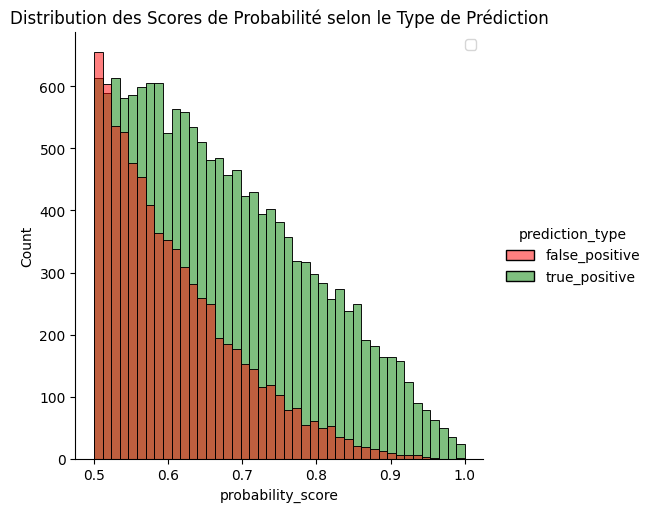

In [22]:
plot_probability_distribution(
    X=X_test_copy,
    prediction_col="prediction",
    target_col="classification_target",
    prob_col="probability_score",
    color_palette=color_palette,
    categories_to_exclude=["true_negative","false_negative"] )

## Analyse de la distribution des erreurs dans les variables numeriques

In [23]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def get_data_group(X, group_label):
    """
    Extrait les observations appartenant à un groupe spécifique.
    """
    if group_label == "all":
        X_group = X.copy()
    else:
        X_group = X[X["prediction_type"] == group_label]
    return X_group

def compare_all_features_distribution_groups(
    X, group_1, group_2, numerical_features=None, scaler=None
):
    """
    Compare les distributions des variables numériques entre deux groupes,
    avec l'option d'afficher les valeurs avant standardisation si un scaler est fourni.

    Arguments :
        - X : DataFrame contenant les données
        - group_1 : Nom du premier groupe
        - group_2 : Nom du deuxième groupe
        - numerical_features : Liste des variables numériques à analyser (facultatif)
        - scaler : L'objet StandardScaler utilisé pour la normalisation (facultatif)
    """
    # Filtrage des groupes
    X_group_1 = get_data_group(X, group_1)
    X_group_1 = X_group_1.copy()
    X_group_1.loc[:, "group"] = group_1

    X_group_2 = get_data_group(X, group_2)
    X_group_2 = X_group_2.copy()
    X_group_2.loc[:, "group"] = group_2

    # Fusionner les groupes
    X_plot = pd.concat([X_group_1, X_group_2], axis=0)

    # Détection automatique des variables numériques si non spécifiées
    if numerical_features is None:
        numerical_features = X_plot.select_dtypes(include="number").columns.tolist()

    # Si un scaler est fourni, inverser la transformation
    if scaler is not None:
        X_plot[numerical_features] = scaler.inverse_transform(X_plot[numerical_features])

    # Création des sous-graphiques
    num_features = len(numerical_features)
    ncols = 2  # Nombre de colonnes dans la grille
    nrows = (num_features + ncols - 1) // ncols  # Calcul du nombre de lignes

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()  # Aplatir pour itérer facilement

    for i, feature in enumerate(numerical_features):
        sns.histplot(
            data=X_plot,
            x=feature,
            hue="group",
            kde=True,
            ax=axes[i],
            palette="tab10",
            alpha=0.5
        )
        axes[i].set_title(f"Distribution of {feature}: {group_1} vs {group_2}")
        axes[i].set_xlabel("Value (before scaling)")  # Affichage des valeurs avant standardisation
        axes[i].set_ylabel("Density")

    # Supprimer les axes inutilisés si le nombre de variables est impair
    for j in range(len(numerical_features), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()




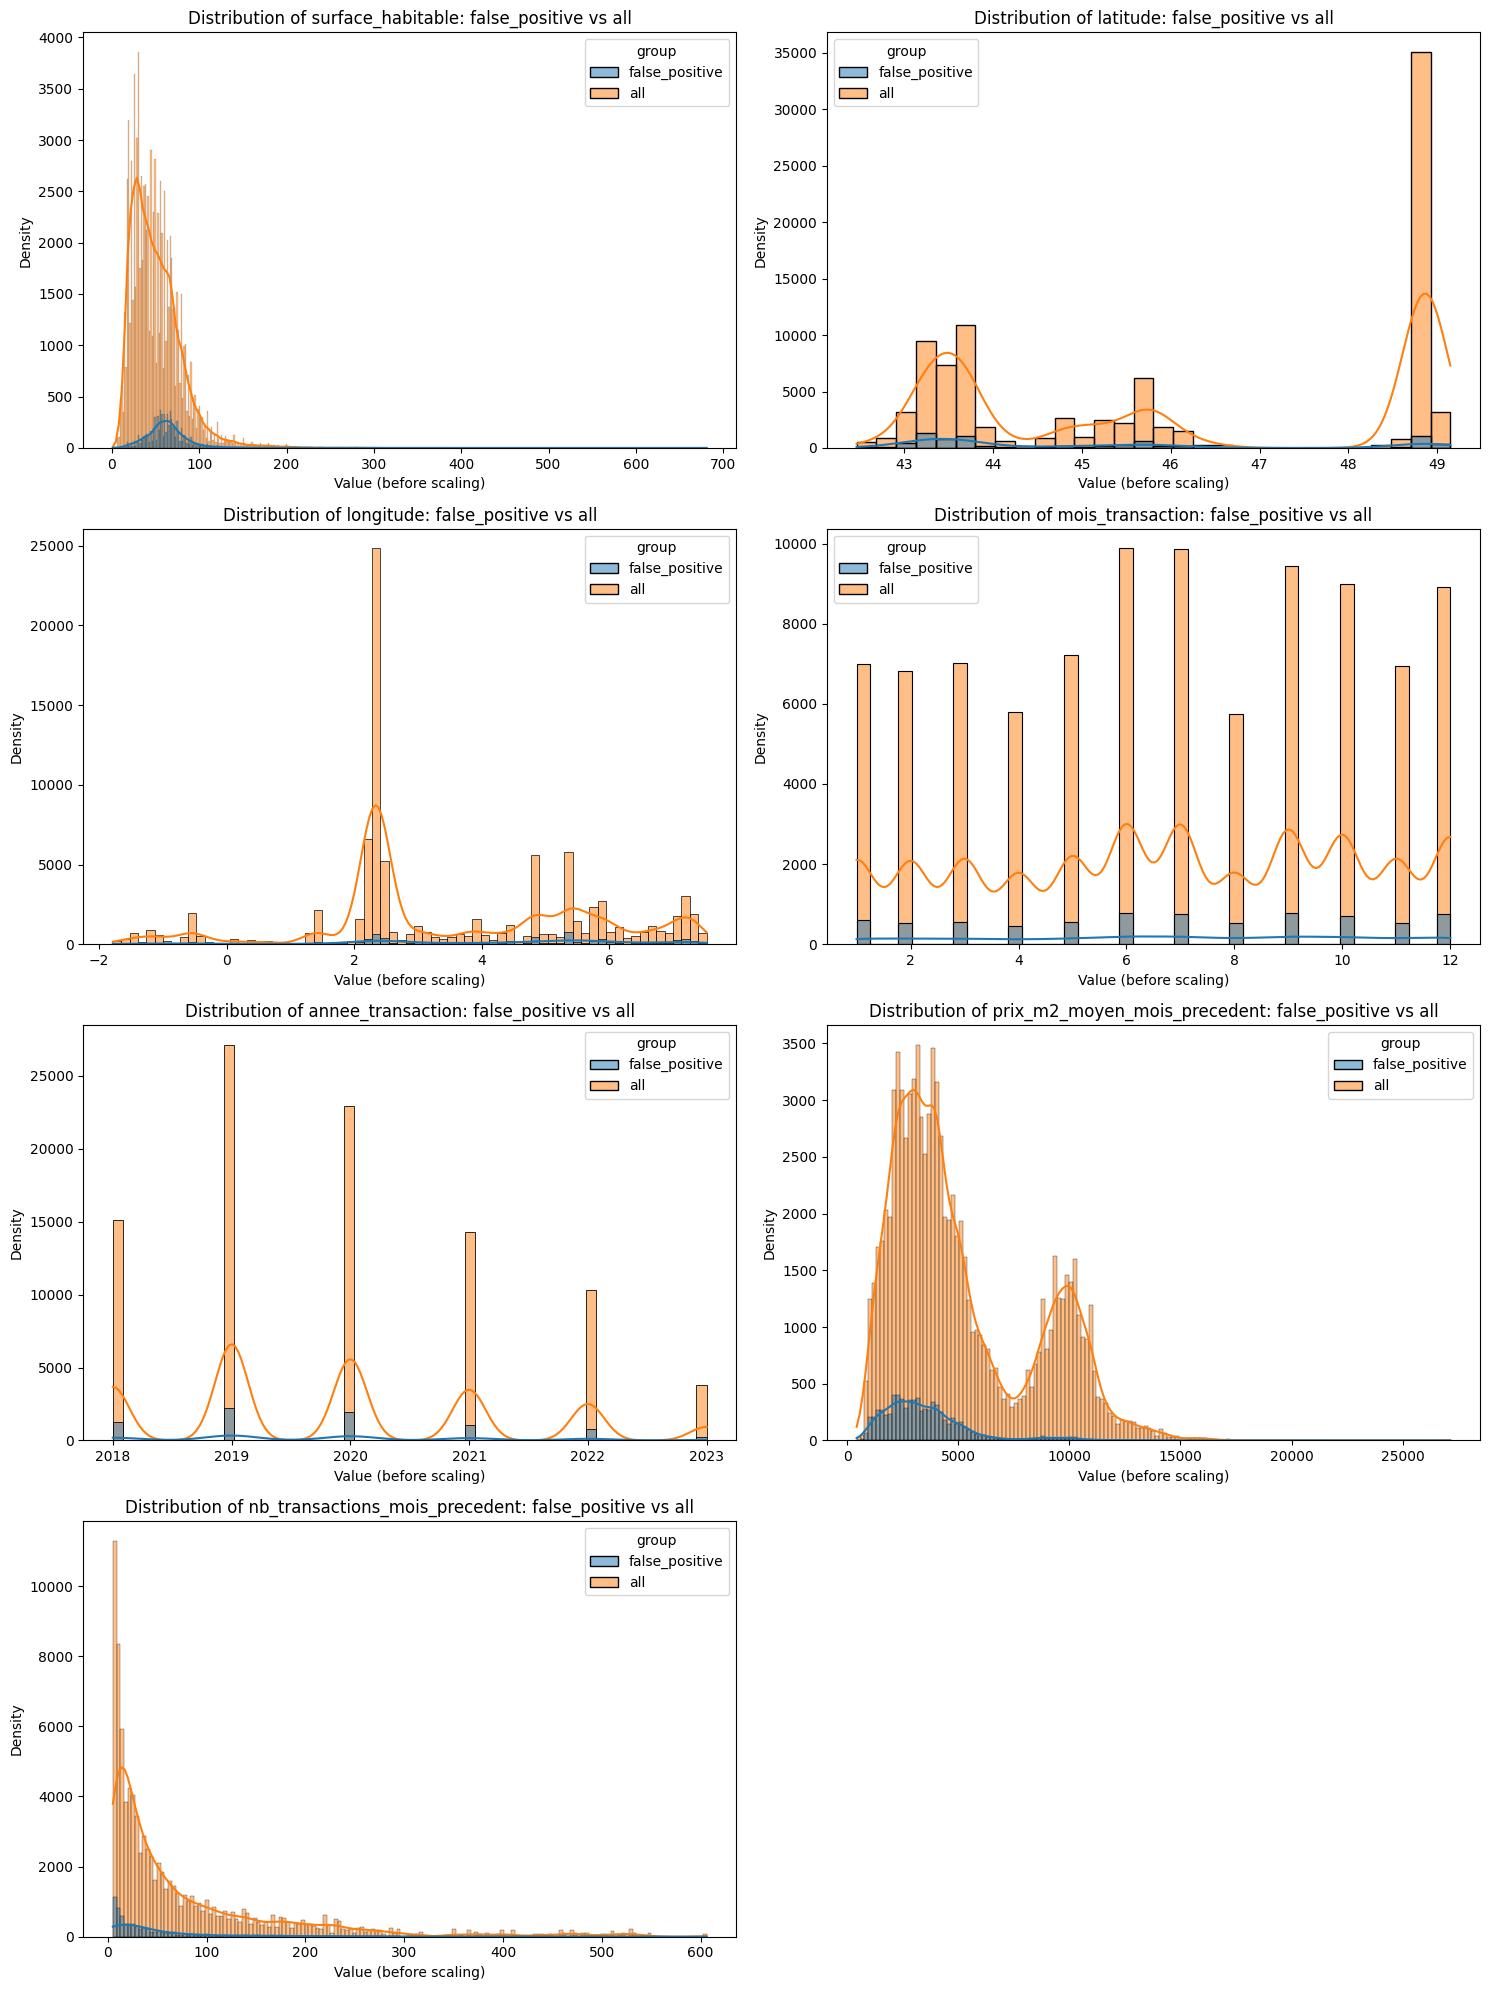

In [24]:

compare_all_features_distribution_groups(X_test_copy, "false_positive", "all", numerical_features=numerical_features, scaler=None)


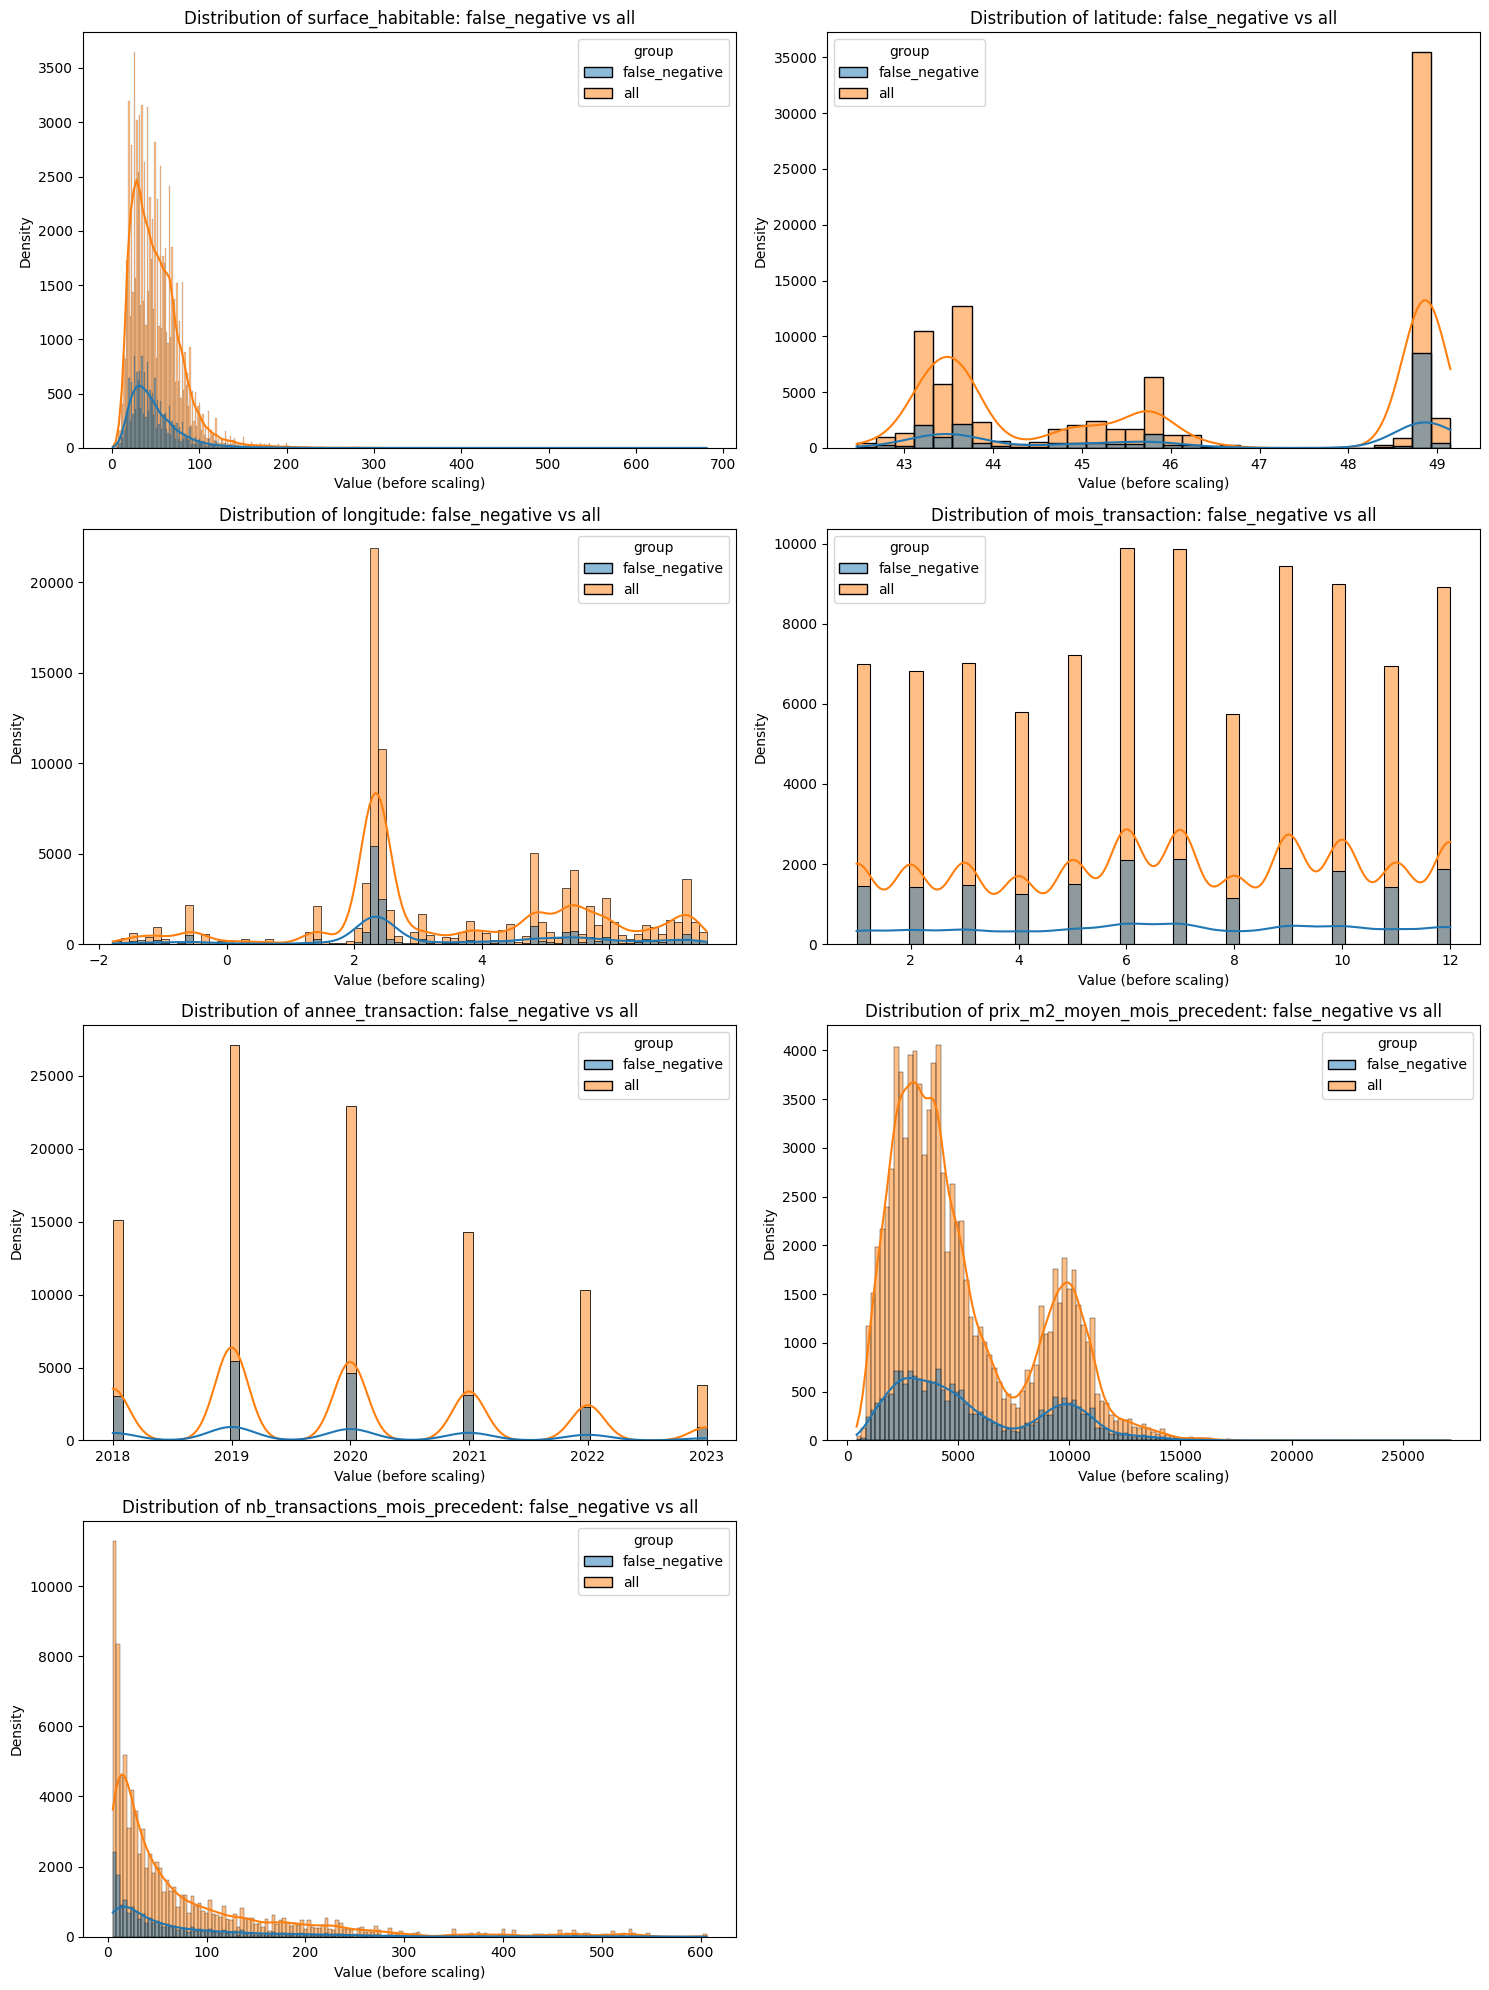

In [25]:
compare_all_features_distribution_groups(X_test_copy, "false_negative", "all", numerical_features=numerical_features, scaler=None)

## Analyse de la distribution des erreurs dans les variables categoriques

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_categorical_features_distribution(X, categorical_features, group_1, group_2):
    """
    Génère un graphique de distribution pour chaque feature catégorielle, en comparant
    la distribution des catégories entre deux groupes (par exemple, faux positifs et global).

    Parameters:
    - X: DataFrame contenant les données
    - categorical_features: Liste des noms des features catégorielles à analyser
    - group_1: Label du premier groupe (ex: "false_positive")
    - group_2: Label du second groupe (ex: "all")
    """
    # Itération sur chaque feature catégorielle
    for feature in categorical_features:
        # Sélection des données des deux groupes
        X_group_1 = get_data_group(X, group_1)
        X_group_2 = get_data_group(X, group_2)

        # Compte les occurrences normalisées par catégorie
        counts_group_1 = X_group_1[feature].value_counts(normalize=True)
        counts_group_2 = X_group_2[feature].value_counts(normalize=True)

        # Création d'un DataFrame pour la comparaison
        df_comparison = pd.DataFrame({
            group_1: counts_group_1,
            group_2: counts_group_2
        }).fillna(0)  # Remplit les catégories manquantes avec 0

        # Tracer le graphique en barres
        df_comparison.plot(kind='bar', figsize=(8, 5))
        plt.title(f"Distribution of {feature}: {group_1} vs {group_2}")
        plt.ylabel("Proportion")
        plt.xlabel("Categories")
        plt.xticks(rotation=45)
        plt.legend(title="Group")
        plt.tight_layout()  # Ajuste la mise en page pour éviter le chevauchement
        plt.show()




In [27]:
from joblib import load

# Charger l'encodeur depuis le fichier
nom_region_encoder = load('../preprocessing/encoders/nom_region_encoder.joblib')
type_batiment_encoder = load('../preprocessing/encoders/type_batiment_encoder.joblib')

In [28]:
from sklearn.preprocessing import OneHotEncoder
from typing import Dict


def inverse_onehot_encoding(df: pd.DataFrame, column: str, encoder_dict: Dict[str, OneHotEncoder]) -> pd.DataFrame:
    """
    Inverse le One-Hot Encoding d'une colonne pour récupérer les catégories d'origine.

    Args:
        df (pd.DataFrame): DataFrame contenant les colonnes encodées.
        column (str): Nom de la colonne d'origine à réencoder.
        encoder_dict (Dict[str, OneHotEncoder]): Dictionnaire contenant la colonne et son encodeur.

    Returns:
        pd.DataFrame: DataFrame avec la colonne inversée à ses valeurs d'origine.
    """
    # Vérifier que l'encodeur pour la colonne existe dans le dictionnaire
    if column not in encoder_dict:
        raise ValueError(f"Aucun encodeur trouvé pour la colonne '{column}' dans le dictionnaire.")

    # Récupérer l'encodeur
    encoder = encoder_dict[column]

    # Extraire les colonnes encodées correspondant à cette colonne
    encoded_columns = encoder.get_feature_names_out([column])

    # Sélectionner les colonnes encodées dans le DataFrame
    encoded_df = df[encoded_columns]

    # Inverser le One-Hot Encoding pour récupérer les valeurs d'origine
    original_values = encoder.inverse_transform(encoded_df)

    # Ajouter la colonne originale au DataFrame (aplatissement en 1D)
    df[column] = original_values.ravel()

    # Supprimer les colonnes encodées
    df = df.drop(columns=encoded_columns)

    return df


In [29]:
X_test_categorical_analysis = X_test.copy()

In [30]:
# Inversion du One-Hot Encoding
df_one_hot_inverted = inverse_onehot_encoding(X_test_copy, 'type_batiment', type_batiment_encoder)



In [31]:
df_one_hot_inverted = inverse_onehot_encoding( df_one_hot_inverted, 'nom_region', nom_region_encoder)

In [32]:
df_one_hot_inverted.head()

,vefa,surface_habitable,latitude,longitude,mois_transaction,annee_transaction,prix_m2_moyen_mois_precedent,nb_transactions_mois_precedent,ville_demandee,prediction,probability_score,classification_target,prediction_type,type_batiment,nom_region
176605,0,61,45.438296,4.389209,3,2021,1054.82,130.0,1,0,0.422739,0,true_negative,Appartement,Auvergne-Rhône-Alpes
123391,0,35,44.824960,-0.597963,2,2019,4747.21,125.0,1,1,0.511804,0,false_positive,Appartement,Nouvelle-Aquitaine
342233,0,87,48.753156,2.634175,6,2020,3372.36,5.0,0,0,0.196922,0,true_negative,Maison,Île-de-France
147447,0,31,43.608599,3.874839,12,2020,3069.09,98.0,1,0,0.144183,0,true_negative,Appartement,Occitanie
185644,0,34,43.382322,-1.650237,2,2020,5613.85,15.0,0,1,0.532624,1,true_positive,Appartement,Nouvelle-Aquitaine


In [35]:
categorical_features_updated=  df_one_hot_inverted.select_dtypes(exclude=['float','int']).columns.to_list()
# Ajouter la colonne 'vefa' si elle n'est pas déjà incluse
if 'vefa' in df_one_hot_inverted.columns and 'vefa' not in categorical_features_updated:
    categorical_features_updated.append('vefa')

In [36]:
# Ajouter la colonne 'ville_demandee' si elle n'est pas déjà incluse
if 'ville_demandee' in df_one_hot_inverted.columns and 'ville_demandee' not in categorical_features_updated:
    categorical_features_updated.append('ville_demandee')

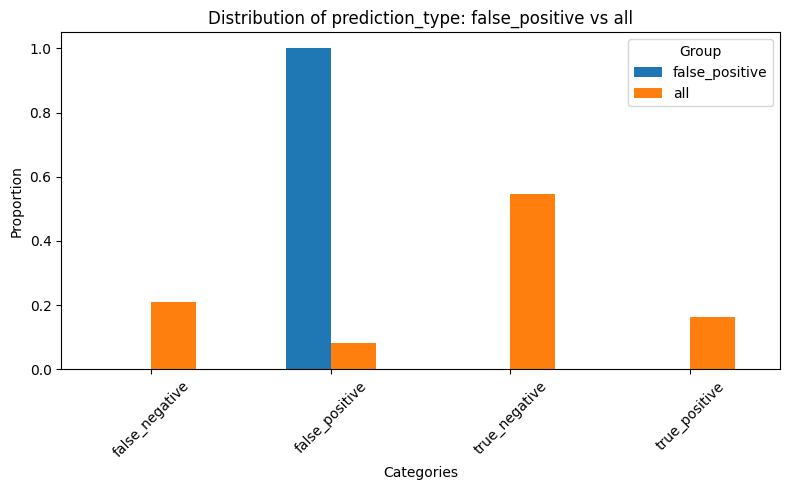

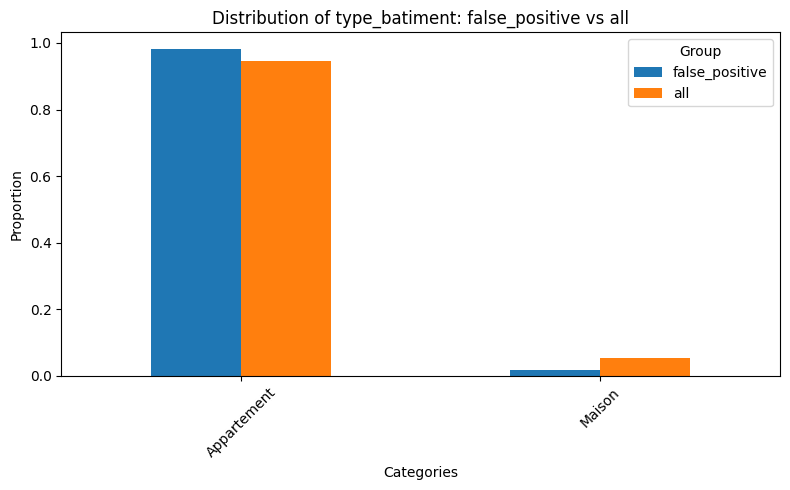

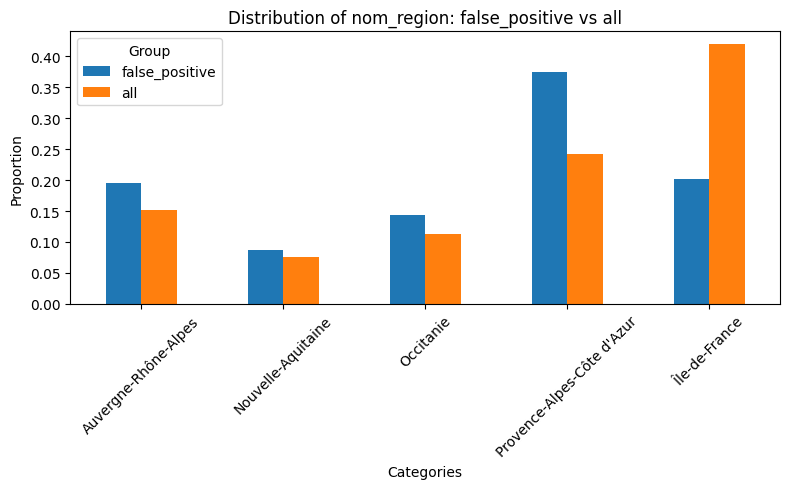

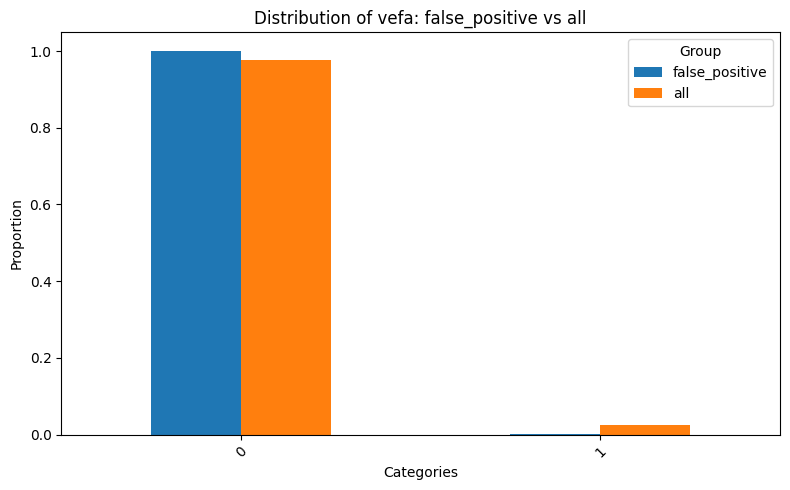

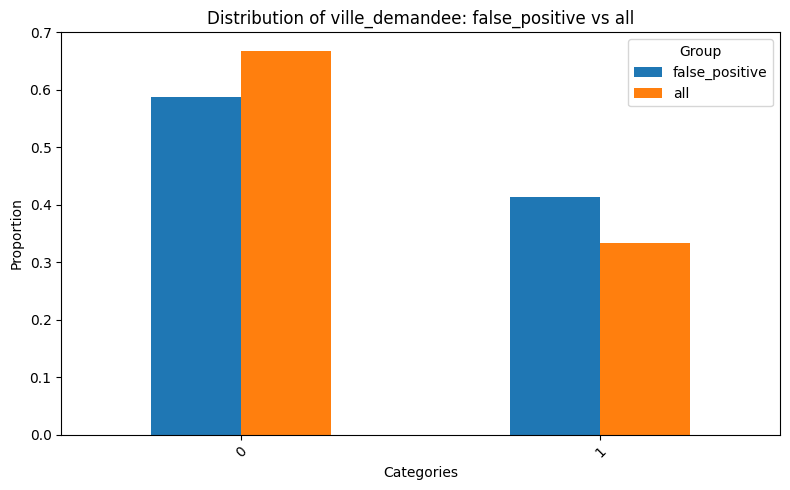

In [37]:

plot_categorical_features_distribution(df_one_hot_inverted, categorical_features_updated, "false_positive", "all")


In [49]:
def plot_error_boxplot(X, categorical_features):

    for feature in categorical_features:
        plt.figure()
        sns.boxplot(x=X[feature], y=X["error"])
        plt.ylabel("Error")
        plt.xlabel(feature)
        plt.xticks(rotation=70)
        plt.title("Boxplot of Error vs {feature}")
        plt.show()

In [45]:
errors = y_test_classification - y_scores_test
df_one_hot_inverted ['error']=errors

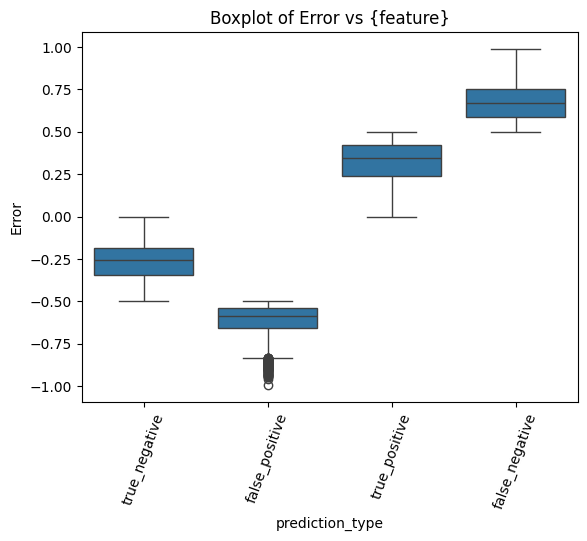

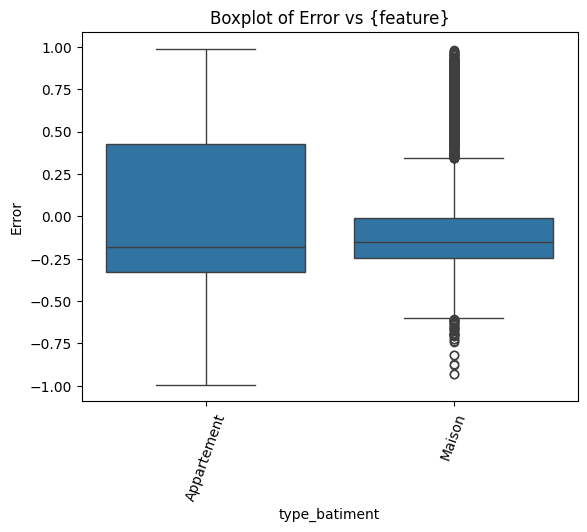

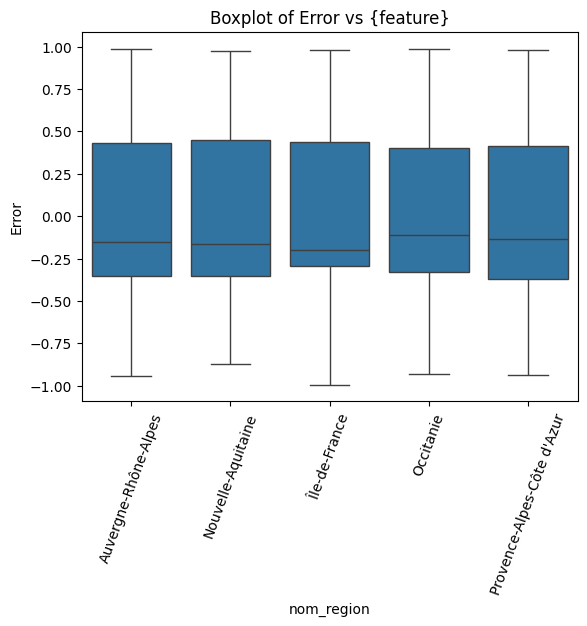

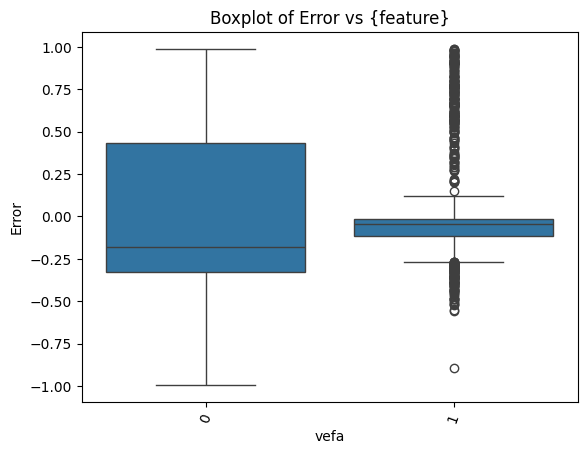

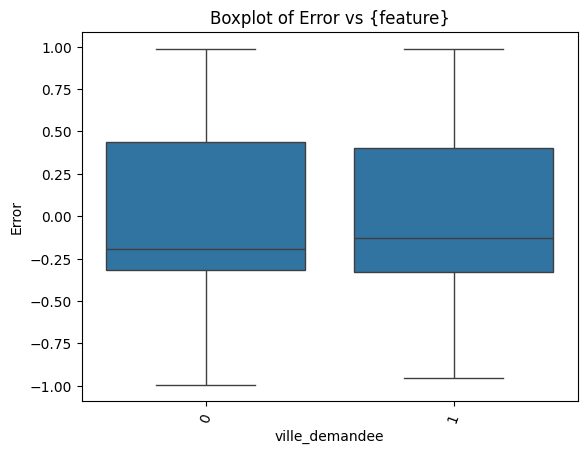

In [50]:
plot_error_boxplot(df_one_hot_inverted,categorical_features_updated)